In [1]:
import time
import torch
import GPUtil
import numpy as np
from utils import *
import torch.nn as nn
import pennylane as qml
from typing import List
from qudit_mapping import *
from qutrit_synthesis import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import combinations
import torch.distributions as dists
from scipy.linalg import norm, orth
from scipy.sparse.linalg import eigsh
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix, eye

np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=8, linewidth=200)

In [ ]:
coeff = 4
coeff_funcs = [
    lambda cos_sim: coeff * cos_sim,
    lambda cos_sim: (coeff * cos_sim).ceil(),
    lambda cos_sim: coeff * cos_sim.pow(2),
    lambda cos_sim: coeff * (2 * cos_sim - cos_sim.pow(2)),
]
cos_sim = torch.arange(0, 1, 1e-3)

for coeff_func in coeff_funcs:
    plt.plot(cos_sim, coeff_func(cos_sim))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, coeff + 1, coeff + 2))
plt.grid()

In [ ]:
import torch
import GPUtil
import numpy as np
import torch.nn as nn
import pennylane as qml
from typing import List
from utils import fidelity
from scipy.io import loadmat
import torch.nn.functional as F
from itertools import combinations
import torch.distributions as dists
from torch.utils.data import DataLoader
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=15, linewidth=200)
torch.set_printoptions(precision=15, linewidth=200)

n_test = 1
name = 'VGON_nqd7_20241020_215744'
if True:
    load = loadmat(f'./mats/{name}.mat')
    n_qudits = load['n_qudits'].item()
    n_qubits = load['n_qubits'].item()
    batch_size = load['batch_size'].item()

    n_layers = 2
    beta = -1 / 3
    n_samples = batch_size * n_test
    n_params = n_layers * (n_qudits - 1) * NUM_PR

    z_dim = 50
    list_z = np.arange(np.floor(np.log2(n_params)), np.ceil(np.log2(z_dim)) - 1, -1)
    h_dim = np.power(2, list_z).astype(int)

    dev = qml.device('default.qubit', n_qubits)
    gpu_memory = gpu[0].memoryUtil if (gpu := GPUtil.getGPUs()) else 1
    if torch.cuda.is_available() and gpu_memory < 0.5 and n_qubits >= 14:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    def spin_operator(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        sx = qml.X(obj[0]) + qml.X(obj[1])
        sy = qml.Y(obj[0]) + qml.Y(obj[1])
        sz = qml.Z(obj[0]) + qml.Z(obj[1])
        return sx, sy, sz

    def spin_operator2(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        s1 = spin_operator(obj)
        s2 = [i @ j for i in s1 for j in s1]
        return s2

    def Hamiltonian(n_qudits: int, beta: float):
        ham1, ham2 = 0, 0
        for i in range(n_qudits - 1):
            obj1 = [2 * i, 2 * i + 1]
            obj2 = [2 * i + 2, 2 * i + 3]
            ham1 += qml.sum(*[spin_operator(obj1)[i] @ spin_operator(obj2)[i] for i in range(3)])
            ham2 += qml.sum(*[spin_operator2(obj1)[i] @ spin_operator2(obj2)[i] for i in range(9)])
        ham = ham1 / 4 - beta * ham2 / 16
        coeffs, obs = qml.simplify(ham).terms()
        coeffs = torch.tensor(coeffs).real
        return qml.Hamiltonian(coeffs, obs)

    def qutrit_symmetric_ansatz(params: torch.Tensor):
        for i in range(n_qudits - 1):
            obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
            two_qutrit_unitary_synthesis(params[i], obj)

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_state(n_layers: int, params: torch.Tensor):
        params = params.transpose(0, 1).reshape(n_layers, n_qudits - 1, NUM_PR, batch_size)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.state()

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_expval(n_layers: int, params: torch.Tensor, Ham):
        params = params.transpose(0, 1).reshape(n_layers, n_qudits - 1, NUM_PR, batch_size)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.expval(Ham)

    class VAE_Model(nn.Module):

        def __init__(self, n_params: int, z_dim: int, h_dim: List[int]):
            super(VAE_Model, self).__init__()
            # encoder
            self.e1 = nn.ModuleList([nn.Linear(n_params, h_dim[0], bias=True)])
            self.e1 += [nn.Linear(h_dim[i - 1], h_dim[i], bias=True) for i in range(1, len(h_dim))]
            self.e2 = nn.Linear(h_dim[-1], z_dim, bias=True)
            self.e3 = nn.Linear(h_dim[-1], z_dim, bias=True)
            # decoder
            self.d4 = nn.ModuleList([nn.Linear(z_dim, h_dim[-1], bias=True)])
            self.d4 += [nn.Linear(h_dim[-i + 1], h_dim[-i], bias=True) for i in range(2, len(h_dim) + 1)]
            self.d5 = nn.Linear(h_dim[0], n_params, bias=True)

        def encoder(self, x):
            h = F.relu(self.e1[0](x))
            for i in range(1, len(self.e1)):
                h = F.relu(self.e1[i](h))
            mean = self.e2(h)
            log_var = self.e3(h)
            return mean, log_var

        def reparameterize(self, mean, log_var):
            eps = torch.randn(log_var.shape).to(device)
            std = torch.exp(log_var).pow(0.5)
            z = mean + std * eps
            return z

        def decoder(self, z):
            params = F.relu(self.d4[0](z))
            for i in range(1, len(self.d4)):
                params = F.relu(self.d4[i](params))
            params = self.d5(params)
            return params

        def forward(self, x):
            mean, log_var = self.encoder(x)
            z = self.reparameterize(mean, log_var)
            params = self.decoder(z)
            return params, mean, log_var

    state_dict = torch.load(f'./mats/{name}.pt', map_location=device, weights_only=True)
    model = VAE_Model(n_params, z_dim, h_dim).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    data_dist = dists.Uniform(0, 1).sample([n_samples, n_params])
    test_data = DataLoader(data_dist, batch_size=batch_size, shuffle=True, drop_last=True)

    Ham = Hamiltonian(n_qudits, beta)
for i, batch in enumerate(test_data):
    param, _, _ = model(batch.to(device))

    cos_sims = torch.empty((0), device=device)
    for ind in combinations(range(batch_size), 2):
        sim = torch.cosine_similarity(param[ind[0], :], param[ind[1], :], dim=0)
        cos_sims = torch.cat((cos_sims, sim.unsqueeze(0)), dim=0)
    print(f'Cos_Sim: {cos_sims.mean():.15f}, {cos_sims.max():.12f}, {cos_sims.min():.12f}')

    state = circuit_state(n_layers, param)
    fidelities = torch.empty((0), device=device)
    for ind in combinations(range(batch_size), 2):
        fidelity = qml.math.fidelity_statevector(state[ind[0]], state[ind[1]])
        fidelities = torch.cat((fidelities, fidelity.unsqueeze(0)), dim=0)
    print(f'Fidelity: {fidelities.mean():.15f}, {fidelities.max():.12f}, {fidelities.min():.12f}')

    energy = circuit_expval(n_layers, param, Ham)
    print(f'Energy: {energy.mean():.15f}, {energy.max():.12f}, {energy.min():.12f}')

    for i, ind in enumerate(combinations(range(batch_size), 2)):
        print(f'{ind}: Cos_Sim: {cos_sims[i]:.15f}, Fidelity: {fidelities[i]:.15f}')

In [33]:
import time
import torch
import GPUtil
import numpy as np
import torch.nn as nn
import pennylane as qml
from typing import List
import torch.nn.functional as F
from itertools import combinations
import torch.distributions as dists
from torch.utils.data import DataLoader
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=15, linewidth=200)
torch.set_printoptions(precision=15, linewidth=200)

n_iter = 100
n_qudits = 4
if True:
    n_layers = 2
    batch_size = 1
    n_qubits = 2 * n_qudits
    n_samples = batch_size * n_iter
    n_params = n_layers * (n_qudits - 1) * NUM_PR

    z_dim = 50
    list_z = np.arange(np.floor(np.log2(n_params)), np.ceil(np.log2(z_dim)) - 1, -1)
    h_dim = np.power(2, list_z).astype(int)

    dev = qml.device('default.qubit', n_qubits)
    gpu_memory = gpu[0].memoryUtil if (gpu := GPUtil.getGPUs()) else 1
    if torch.cuda.is_available() and gpu_memory < 0.5 and n_qubits >= 14:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f'PyTorch Device: {device}')

    def qutrit_symmetric_ansatz(params: torch.Tensor):
        for i in range(n_qudits - 1):
            obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
            two_qutrit_unitary_synthesis(params[i], obj)

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_state_init(n_layers: int, params: torch.Tensor):
        params = params.reshape(n_layers, n_qudits - 1, NUM_PR)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.state()

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_state(n_layers: int, params: torch.Tensor):
        params = params.transpose(0, 1).reshape(n_layers, n_qudits - 1, NUM_PR, batch_size)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.state()

    class VAE_Model(nn.Module):

        def __init__(self, n_params: int, z_dim: int, h_dim: List[int]):
            super(VAE_Model, self).__init__()
            # encoder
            self.e1 = nn.ModuleList([nn.Linear(n_params, h_dim[0], bias=True)])
            self.e1 += [nn.Linear(h_dim[i - 1], h_dim[i], bias=True) for i in range(1, len(h_dim))]
            self.e2 = nn.Linear(h_dim[-1], z_dim, bias=True)
            self.e3 = nn.Linear(h_dim[-1], z_dim, bias=True)
            # decoder
            self.d4 = nn.ModuleList([nn.Linear(z_dim, h_dim[-1], bias=True)])
            self.d4 += [nn.Linear(h_dim[-i + 1], h_dim[-i], bias=True) for i in range(2, len(h_dim) + 1)]
            self.d5 = nn.Linear(h_dim[0], n_params, bias=True)

        def encoder(self, x):
            h = F.relu(self.e1[0](x))
            for i in range(1, len(self.e1)):
                h = F.relu(self.e1[i](h))
            mean = self.e2(h)
            log_var = self.e3(h)
            return mean, log_var

        def reparameterize(self, mean, log_var):
            eps = torch.randn(log_var.shape).to(device)
            std = torch.exp(log_var).pow(0.5)
            z = mean + std * eps
            return z

        def decoder_expval(self, z):
            params = F.relu(self.d4[0](z))
            for i in range(1, len(self.d4)):
                params = F.relu(self.d4[i](params))
            params = self.d5(params)
            return circuit_expval(n_layers, params, Ham)

        def decoder(self, z):
            params = F.relu(self.d4[0](z))
            for i in range(1, len(self.d4)):
                params = F.relu(self.d4[i](params))
            params = self.d5(params)
            return params

        def forward(self, x):
            mean, log_var = self.encoder(x)
            z = self.reparameterize(mean, log_var)
            params = self.decoder(z)
            return params, mean, log_var

    param_init = torch.Tensor(np.random.uniform(0, 1, n_params))
    state_init = circuit_state_init(n_layers, param_init).to(device)

    model = VAE_Model(n_params, z_dim, h_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    data_dist = dists.Uniform(0, 1).sample([n_samples, n_params])
    train_data = DataLoader(data_dist, batch_size=batch_size, shuffle=True, drop_last=True)

    start = time.perf_counter()
    params = torch.empty((0), device=device)
    states = torch.empty((0), device=device)
    fidelities = torch.empty((0), device=device)
for i, batch in enumerate(train_data):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    param, _, _ = model(batch.to(device))
    params = torch.cat((params, param), dim=0)

    state = circuit_state(n_layers, param)
    states = torch.cat((states, state), dim=0)

    fidelity = qml.math.fidelity_statevector(state_init, state)
    fidelities = torch.cat((fidelities, fidelity), dim=0)

    loss = fidelity.squeeze(0)
    loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        t = time.perf_counter() - start
        print(f'Loss: {loss:.15f}, {loss:.8e}, {i+1}/{n_iter}, {t:.2f}')
f_sort, f_ind = fidelities.sort()
f_sort, f_ind

PyTorch Device: cpu
Loss: 0.001654039641204, 1.65403964e-03, 10/100, 6.83
Loss: 0.002027991366493, 2.02799137e-03, 20/100, 13.74
Loss: 0.000184346426887, 1.84346427e-04, 30/100, 20.44
Loss: 0.000011197907596, 1.11979076e-05, 40/100, 27.42
Loss: 0.000053726928490, 5.37269285e-05, 50/100, 34.14
Loss: 0.000013132954643, 1.31329546e-05, 60/100, 40.93
Loss: 0.000020233486604, 2.02334866e-05, 70/100, 47.90
Loss: 0.000004479102922, 4.47910292e-06, 80/100, 54.84
Loss: 0.000037838427625, 3.78384276e-05, 90/100, 61.76
Loss: 0.000044626078335, 4.46260783e-05, 100/100, 68.49


(tensor([2.345111960875684e-07, 2.679662310753447e-07, 3.912735636975606e-07, 1.599461376066622e-06, 1.704932081242104e-06, 1.807111575867498e-06, 2.027017170561015e-06, 2.398879792958480e-06,
         2.465033641709405e-06, 3.693671729104641e-06, 4.043071559049409e-06, 4.479102922481346e-06, 4.777046310181865e-06, 4.785088291654631e-06, 6.511149388066303e-06, 7.162769901363276e-06,
         7.217417310671709e-06, 8.882931504046439e-06, 1.007495005346149e-05, 1.119790759550188e-05, 1.159773668282515e-05, 1.313295464310363e-05, 1.363957780561105e-05, 1.391994763302792e-05,
         1.403310007724722e-05, 1.569470873058667e-05, 1.638314357419494e-05, 1.732164988358530e-05, 1.788567163898627e-05, 1.847735183481462e-05, 2.023348660449324e-05, 2.077795861494082e-05,
         2.111276707381553e-05, 2.349374754351432e-05, 2.352171606885863e-05, 2.487247506822551e-05, 2.495684672123887e-05, 2.522185049922480e-05, 2.604882494074589e-05, 2.604966794662877e-05,
         2.658920853742371e-05, 2.8

In [67]:
def KL_div(p, q):
    p = torch.softmax(p, dim=0)
    q = torch.softmax(q, dim=0)
    return (p * (p.log2() - q.log2())).sum().unsqueeze(0)


def JS_div(p, q):
    p = torch.softmax(p, dim=0)
    q = torch.softmax(q, dim=0)
    return (p * p.log2() / 2 + q * q.log2() / 2 - (p + q) * ((p + q) / 2).log2() / 2).sum().unsqueeze(0)


def H_distance(p, q):
    p = torch.softmax(p, dim=0)
    q = torch.softmax(q, dim=0)
    return ((p.sqrt() - q.sqrt()).pow(2).sum() / 2).sqrt().unsqueeze(0)


KL_divs = torch.empty((0), device=device)
JS_divs = torch.empty((0), device=device)
cos_sims = torch.empty((0), device=device)
H_dist = torch.empty((0), device=device)
for i in range(n_iter):
    cos_sim = torch.cosine_similarity(param_init, params[i], dim=0)
    cos_sims = torch.cat((cos_sims, cos_sim.unsqueeze(0)), dim=0)
    KL_divs = torch.cat((KL_divs, KL_div(param_init, params[i])), dim=0)
    JS_divs = torch.cat((JS_divs, JS_div(param_init, params[i])), dim=0)
    H_dist = torch.cat((H_dist, H_distance(param_init, params[i])), dim=0)

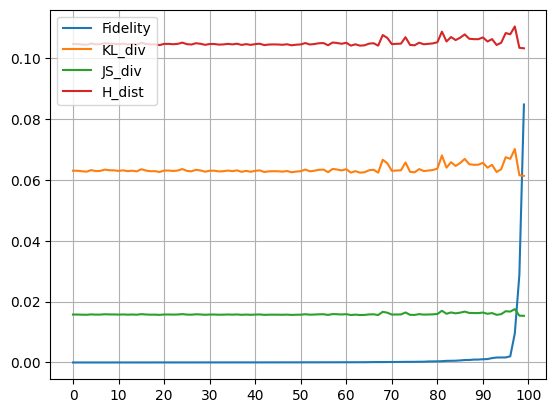

In [68]:
import matplotlib.pyplot as plt


def plot(x: torch.Tensor, label: str):
    plt.plot(np.arange(n_iter), x.detach().numpy(), label=label)


plot(f_sort, 'Fidelity')
# plot(cos_sims[f_ind], 'Cos_Sim')
plot(KL_divs[f_ind], 'KL_div')
plot(JS_divs[f_ind], 'JS_div')
plot(H_dist[f_ind], 'H_dist')
plt.xticks(np.linspace(0, n_iter, 11))
# plt.yscale('log')
plt.legend()
plt.grid()

In [ ]:
def qutrit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qutrit_spin_operator(n_qudits, is_csr=True)
    s2 = qutrit_spin_operator2(n_qudits, is_csr=True)
    Ham = s1 - beta * s2
    if is_csr:
        return Ham
    return Ham.toarray()


sx = csr_matrix([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
sy = csr_matrix([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)
sz = csr_matrix([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
s_list = [sx, sy, sz]
s2_list = [i @ j for i in s_list for j in s_list]
sym_list = [symmetric_encoding(i, is_csr=True) for i in s_list]
sym2_list = [i @ j for i in sym_list for j in sym_list]

beta = -1 / 3
n_qudits = 10
n_qubits = 2 * n_qudits
t1 = time.perf_counter()
ham = qutrit_Hamiltonian(n_qudits, beta, is_csr=True)
t2 = time.perf_counter()
print('Time:', t2 - t1)
eigvals, eigvecs = eigsh(ham, k=4, which='SA')
t3 = time.perf_counter()
print('Time:', t3 - t2)
eigvecs = orth(eigvecs)
t4 = time.perf_counter()
print('Time:', t4 - t3)

for name in range(len(eigvals)):
    print(np.allclose(ham @ eigvecs[:, name], eigvals[name] * eigvecs[:, name], atol=1e-14), norm(eigvecs[:, name], 2), eigvals)
for name in combinations(range(len(eigvals)), 2):
    print(name, fidelity(eigvecs[:, name[0]], eigvecs[:, name[1]]))
t5 = time.perf_counter()
print('Time:', t5 - t4)

mat_path = f'./mats/ED_degeneracy.mat'
# updatemat(mat_path, {f'nqd{n_qudits}': (eigvals, eigvecs)})

In [ ]:
import time
import torch
import numpy as np
import pennylane as qml
from typing import List
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=4, linewidth=200)


def running(n_qudits: int, epochs: int):
    n_layers = 2
    beta = -1 / 3
    n_qubits = 2 * n_qudits
    dev = qml.device('default.qubit', n_qubits)
    device = torch.device('cpu')

    def spin_operator(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        sx = qml.X(obj[0]) + qml.X(obj[1])
        sy = qml.Y(obj[0]) + qml.Y(obj[1])
        sz = qml.Z(obj[0]) + qml.Z(obj[1])
        return sx, sy, sz

    def spin_operator2(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        s1 = spin_operator(obj)
        s2 = [i @ j for i in s1 for j in s1]
        return s2

    def Hamiltonian(n_qudits: int, beta: float):
        ham1, ham2 = 0, 0
        for i in range(n_qudits - 1):
            obj1 = [2 * i, 2 * i + 1]
            obj2 = [2 * i + 2, 2 * i + 3]
            ham1 += qml.sum(*[spin_operator(obj1)[i] @ spin_operator(obj2)[i] for i in range(3)])
            ham2 += qml.sum(*[spin_operator2(obj1)[i] @ spin_operator2(obj2)[i] for i in range(9)])
        Ham = ham1 / 4 - beta * ham2 / 16
        coeffs, obs = qml.simplify(Ham).terms()
        coeffs = torch.tensor(coeffs).real
        Ham = qml.Hamiltonian(coeffs, obs)
        return Ham

    def qutrit_symmetric_ansatz(params: torch.Tensor):
        for i in range(n_qudits - 1):
            obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
            two_qutrit_unitary_synthesis(params[i], obj)

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_expval(n_layers: int, params: torch.Tensor, Ham):
        params = params.reshape(n_layers, n_qudits - 1, NUM_PR)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.expval(Ham)

    np.random.seed(42)
    n_params = n_layers * (n_qudits - 1) * NUM_PR
    params_init = np.random.uniform(-np.pi, np.pi, n_params)
    params = torch.tensor(params_init, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=1e-3)
    Ham = Hamiltonian(n_qudits, beta)
    print(Ham)

    start = time.perf_counter()
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        loss = circuit_expval(n_layers, params, Ham)
        loss.backward()
        optimizer.step()
        t = time.perf_counter() - start
        print(f'Loss: {loss.item():.20f}, {epoch+1}/{epochs}, {t:.2f}')


running(n_qudits=6, epochs=10)

In [ ]:
def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) + qml.X(obj[1])
    sy = qml.Y(obj[0]) + qml.Y(obj[1])
    sz = qml.Z(obj[0]) + qml.Z(obj[1])
    return sx, sy, sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = spin_operator(obj)
    s2 = [i @ j for i in s1 for j in s1]
    return s2


def Hamiltonian(n_qudits: int, beta: float):
    ham1, ham2 = 0, 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        ham1 += qml.sum(*[spin_operator(obj1)[i] @ spin_operator(obj2)[i] for i in range(3)])
        ham2 += qml.sum(*[spin_operator2(obj1)[i] @ spin_operator2(obj2)[i] for i in range(9)])
    Ham = ham1 / 4 - beta * ham2 / 16
    coeffs, obs = qml.simplify(Ham).terms()
    coeffs = torch.tensor(coeffs).real
    Ham = qml.Hamiltonian(coeffs, obs)
    return Ham


def qutrit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qutrit_spin_operator(n_qudits, is_csr=True)
    s2 = qutrit_spin_operator2(n_qudits, is_csr=True)
    Ham = s1 - beta * s2
    if is_csr:
        return Ham
    return Ham.toarray()


def qubit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((4**n_qudits, 4**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 4**i, 4**(n_qudits - i - 2)
        for j in sym_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qubit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((4**n_qudits, 4**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 4**i, 4**(n_qudits - i - 2)
        for j in sym2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qubit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qubit_spin_operator(n_qudits, is_csr=True)
    s2 = qubit_spin_operator2(n_qudits, is_csr=True)
    if is_csr:
        return s1 - beta * s2
    return (s1 - beta * s2).toarray()


sx = csr_matrix([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
sy = csr_matrix([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)
sz = csr_matrix([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
s_list = [sx, sy, sz]
s2_list = [i @ j for i in s_list for j in s_list]
sym_list = [symmetric_encoding(i, is_csr=True) for i in s_list]
sym2_list = [i @ j for i in sym_list for j in sym_list]

n_qudits, beta = 7, -0.3
Ham = Hamiltonian(n_qudits, beta)
h1 = csr_matrix(Ham.matrix())
h2 = qubit_Hamiltonian(n_qudits, beta, is_csr=True)
h3 = qutrit_Hamiltonian(n_qudits, beta, is_csr=True)

v1 = np.sort(eigsh(h2, k=6, which='SA', return_eigenvectors=False))
v2 = np.sort(eigsh(h2, k=6, which='SA', return_eigenvectors=False))
print(v1)
print(v2)
np.allclose(v1, v2)

In [ ]:
start = time.perf_counter()
print('L', end=' 　')
beta_list = [-0.3, -0.2, -0.1, 0.0, 0.4]
for beta in beta_list:
    if beta < 0:
        print(f'β = {beta:.2f}', end='　')
    else:
        print(f'β = +{beta:.2f}', end='　')
print('Time')
for n_qudits in [4, 5, 6, 7, 8, 9]:
    start_nq = time.perf_counter()
    print(n_qudits, end=' 　')
    s1 = qubit_spin_operator(n_qudits, is_csr=True)
    s2 = qubit_spin_operator2(n_qudits, is_csr=True)
    for beta in beta_list:
        ham = s1 - beta * s2
        eigvals = eigsh(ham, k=4, which='SA', return_eigenvectors=False)
        eigvals = sorted(eigvals)
        vals = np.array(eigvals[:1])
        for v1 in eigvals[1:]:
            for v2 in vals:
                if np.abs(v1 - v2) < 1e-12:
                    break
            else:
                vals = np.append(vals, v1)
        diff = vals[0] - vals[1]
        print(f'{diff:.6f}', end='　')
    end_nq = time.perf_counter()
    print(f'{(end_nq-start_nq):.2f}')
end = time.perf_counter()
total = end - start
if total >= 60:
    print(f'Total time: {total//60:.0f}m{total%60:.2f}s')
else:
    print(f'Total time: {total:.2f}s')

In [ ]:
import time
import torch
import GPUtil
import numpy as np
import pennylane as qml
from typing import List
from utils import updatemat
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=8, linewidth=200)


def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
    return Ham


def qutrit_symmetric_ansatz(n_qudits: int, params: torch.Tensor, Ham):
    params = params.reshape(n_qudits - 1, NUM_PR)
    n_qubits = 2 * n_qudits
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.expval(Ham)


n_qudits, beta, n_iter, lr = 4, -0.3, 10, 0.1
n_qubits = 2 * n_qudits

dev = qml.device('default.qubit', n_qubits)
gpu_memory = gpu[0].memoryUtil if (gpu := GPUtil.getGPUs()) else 1
if torch.cuda.is_available() and gpu_memory < 0.5 and n_qubits >= 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'PyTorch Device: {device}')
print(f'Coefficient beta: {beta}')
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
param = torch.tensor(init_params, device=device, requires_grad=True)
cost_fn = qml.QNode(qutrit_symmetric_ansatz, dev, interface='torch')
optimizer = torch.optim.Adam([param], lr=lr)
Ham = Hamiltonian(n_qudits, beta)

start = time.perf_counter()
for epoch in range(n_iter):
    optimizer.zero_grad()
    loss = cost_fn(n_qudits, param, Ham)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'Loss: {loss.item():.20f}, {count}/{n_iter}, {t:.2f}')

loss_res = loss.detach().cpu()
params_res = optimizer.param_groups[0]['params'][0].detach().cpu()
time_str = time.strftime('%Y%m%d_%H%M%S', time.localtime())
mat_dict = {'n_qudits': n_qudits, 'n_qubits': n_qubits, 'beta': beta, 'epochs': n_iter, \
'learning_rate': lr, 'params_init': init_params, 'params_res': params_res, 'loss': loss_res}
# updatemat(f'./mats/testVQE_{time_str}.mat', mat_dict)
print(mat_dict)

In [ ]:
import time
import torch
import GPUtil
import numpy as np
import pennylane as qml
from typing import List
from utils import updatemat
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis


def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
    return Ham


def qutrit_symmetric_ansatz(n_qudits: int, params: torch.Tensor, Ham):
    params = params.reshape(n_qudits - 1, NUM_PR)
    n_qubits = 2 * n_qudits
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.expval(Ham)


n_qudits = 2
n_qubits = 2 * n_qudits

dev = qml.device('default.qubit', n_qubits)
gpu_memory = gpu[0].memoryUtil if (gpu := GPUtil.getGPUs()) else 1
if torch.cuda.is_available() and gpu_memory < 0.5 and n_qubits >= 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'PyTorch Device: {device}')
print(f'Coefficient beta: {beta}')
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

np.random.seed(42)
pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
param = torch.tensor(init_params, device=device, requires_grad=True)
cost_fn = qml.QNode(qutrit_symmetric_ansatz, dev, interface='torch')
optimizer = torch.optim.Adam([param], lr=0.1)
Ham = Hamiltonian(n_qudits, beta=-1 / 3)

n_iter = 100
start = time.perf_counter()
for epoch in range(n_iter):
    optimizer.zero_grad()
    loss = cost_fn(n_qudits, param, Ham)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'{count:3d}/{n_iter}, Loss: {loss.item():.20f}, {t:.2f}')
params_res = optimizer.param_groups[0]['params'][0].detach()
print(params_res)

In [ ]:
def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
        print(i, obj1, obj2)
    return Ham


n_qudits = 2
Ham = Hamiltonian(n_qudits, 1)
Ham_mat = Ham.matrix()
print(Ham_mat, Ham_mat.shape)

In [ ]:
Sx = {2: np.array([[0, 1], [1, 0]], dtype=CDTYPE) / 2,  \
      3: np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sy = {2: np.array([[0, -1j], [1j, 0]], dtype=CDTYPE) / 2, \
      3: np.array([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sz = {2: np.array([[1, 0], [0, -1]], dtype=CDTYPE) / 2, \
      3: np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=CDTYPE)}

dim = 3
print(Sx[dim])
print(Sy[dim])
print(Sz[dim])

S = Sx[dim] + Sy[dim] + Sz[dim]
print(S)

In [ ]:
import time
import torch
import GPUtil
import numpy as np
from h5py import File
import pennylane as qml
from qudit_mapping import symmetric_encoding
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

path = '../QuditVQE/data_232/from_classical_to_violation_dense'
match = File(f'{path}/232_d3_D9_model1216_RDM2_iter1_target_state_vector.mat')
state = match['target_state_vec'][:].view('complex')
n_qudits = match['N'][0]
match.close()

dim = 3
n_qubits = n_qudits * (dim - 1)

dev = qml.device('default.qubit', n_qubits)
gpu_memory = gpu[0].memoryUtil if (gpu := GPUtil.getGPUs()) else 1
if torch.cuda.is_available() and gpu_memory < 0.5 and n_qubits >= 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'PyTorch Device: {device}')
print(f'Coefficient beta: {beta}')
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

psi_sym = symmetric_encoding(state, n_qudits)
psi_sym = torch.from_numpy(psi_sym)

pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
param = torch.tensor(init_params, device=device, requires_grad=True)
optimizer = torch.optim.Adam([param], lr=0.1)


@qml.qnode(dev, interface='torch')
def qutrit_symmetric_ansatz(params: torch.Tensor):
    params = params.reshape(n_qudits - 1, NUM_PR)
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - (dim - 1) * (i + 2), n_qubits - (dim - 1) * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.state()


def cost_fn(params: torch.Tensor):
    psi_circ = qutrit_symmetric_ansatz(params)
    fidelity = torch.abs(psi_circ.conj() @ psi_sym)**2
    return fidelity


n_iter = 500
start = time.perf_counter()
for epoch in range(n_iter):
    optimizer.zero_grad()
    loss = cost_fn(param)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'{count:3d}/{n_iter}, Loss: {loss.item():.15f}, Fidelity: {1-loss.item():.15f}, {t:.2f}')